# Analise modelos ML

## Carregar dados tratados

In [19]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [20]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from sklearn import metrics

from xgboost import XGBClassifier

import joblib

In [21]:
def carregar_joblib(file_name: str = "../out/result_analise_desc_scaled.joblib"):
    df = joblib.load(file_name)
    return df

## Feature selection

In [22]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)

In [23]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=42)

    print(f"{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}")

    return X_treino, X_teste, y_treino, y_teste

In [83]:
def split_dados_cv(df, model: dict):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    from sklearn import model_selection
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold

    # skfold = model_selection.StratifiedKFold(n_splits=5)

    # results_skfold = model_selection.cross_val_score(model, X, y, cv=skfold)
    # display(results_skfold)
    # print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))

    kfold = KFold(n_splits=5, random_state=42, shuffle=True)

    accuracy_and_data = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        previsoes = model.predict(X_test)

        acc = accuracy_score(previsoes, y_test)
        accuracy_and_data.append({'accuracy': acc, 'split_data': (X_train, X_test, y_train, y_test)})
        
        avaliar(y_test, previsoes, "logReg")
    
    

## Dummy selection para avaliar uma selecao randomica de compra e venda

In [60]:
def run_dummy_classifier(
    X_treino,
    X_teste, 
    y_treino,
    y_teste
):
    dummy = DummyClassifier(strategy="stratified", random_state=42)
    dummy.fit(X_treino, y_treino)
    previsao_dummy = dummy.predict(X_teste)

    # # print dummy results
    avaliar(y_teste, previsao_dummy, "Dummy")
    
    return previsao_dummy

# ML modelos

## Modelos a serem testados

- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Rede Neural

In [87]:
svc=SVC(probability=True, kernel='linear')
log = LogisticRegression(random_state=42)
log_reg = LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg",
                                fit_intercept=True, intercept_scaling=1, l1_ratio=None, penalty="none", warm_start=False)

def definir_modelos_ml() -> dict:
    return {
        # "XGBoost": XGBClassifier(max_depth=9, scale_pos_weight=0.2),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(random_state=42),
        "ExtraTree": ExtraTreesClassifier(random_state=42),
        "GradientBoost": GradientBoostingClassifier(random_state=42),
        # "KNN": KNeighborsClassifier(),
        # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg",
                                # fit_intercept=True, intercept_scaling=1, l1_ratio=None, penalty="none", warm_start=False),
        # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg"),
        "LogisticRegression": LogisticRegression(random_state=42),
        "RedeNeural": MLPClassifier(random_state= 42),
        # "RedeNeural": MLPClassifier(solver= "sgd", random_state= 2, hidden_layer_sizes= 5),
    }



In [61]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    for nome, modelo in modelos.items():
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        avaliar(y_teste, previsoes, nome)
        modelos[nome] = modelo
    
    return modelos

In [59]:
def avaliar(y_teste, y_pred, nome_modelo):
    print(nome_modelo)
    report = classification_report(y_teste, y_pred)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_pred), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("Accuracy:", metrics.accuracy_score(y_teste, y_pred))
    print("#" * 50)
    
    


# Execucao

scaled df
(1852, 6)
Index(['outros_ativos_circ', 'receita_liq', 'resultado_bruto',
       'resultado_antes_trib', 'lucro_op', 'decisao'],
      dtype='object')
len(X_treino)=1389 len(X_teste)=463 len(y_treino)=1389 len(y_teste)=463
Dummy
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       235
           1       0.50      0.50      0.50       228

    accuracy                           0.50       463
   macro avg       0.50      0.50      0.50       463
weighted avg       0.50      0.50      0.50       463



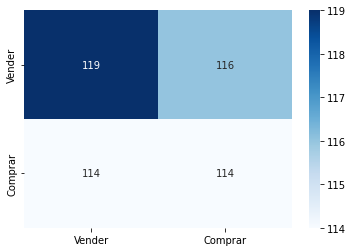

Accuracy: 0.5032397408207343
##################################################
AdaBoost
              precision    recall  f1-score   support

           0       0.57      0.46      0.51       235
           1       0.54      0.64      0.59       228

    accuracy                           0.55       463
   macro avg       0.55      0.55      0.55       463
weighted avg       0.55      0.55      0.55       463



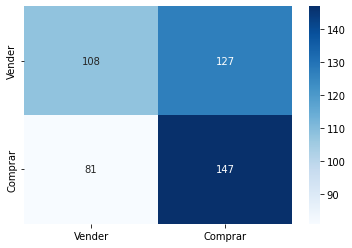

Accuracy: 0.550755939524838
##################################################
DecisionTree
              precision    recall  f1-score   support

           0       0.53      0.47      0.50       235
           1       0.51      0.57      0.54       228

    accuracy                           0.52       463
   macro avg       0.52      0.52      0.52       463
weighted avg       0.52      0.52      0.52       463



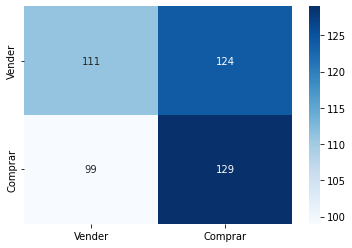

Accuracy: 0.5183585313174947
##################################################
RandomForest
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       235
           1       0.52      0.59      0.55       228

    accuracy                           0.53       463
   macro avg       0.53      0.53      0.53       463
weighted avg       0.53      0.53      0.53       463



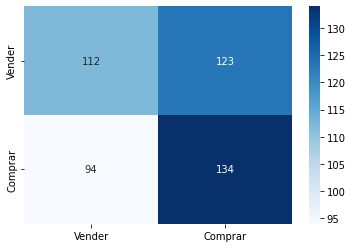

Accuracy: 0.531317494600432
##################################################
ExtraTree
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       235
           1       0.50      0.55      0.53       228

    accuracy                           0.51       463
   macro avg       0.51      0.51      0.51       463
weighted avg       0.51      0.51      0.51       463



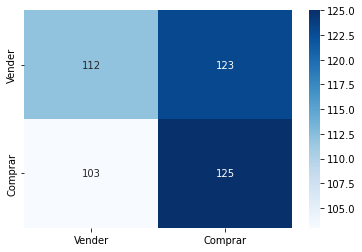

Accuracy: 0.5118790496760259
##################################################
GradientBoost
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       235
           1       0.53      0.66      0.59       228

    accuracy                           0.54       463
   macro avg       0.55      0.55      0.54       463
weighted avg       0.55      0.54      0.54       463



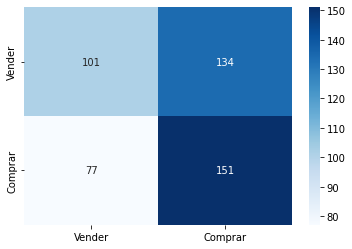

Accuracy: 0.5442764578833693
##################################################
LogisticRegression
              precision    recall  f1-score   support

           0       0.70      0.03      0.06       235
           1       0.50      0.99      0.66       228

    accuracy                           0.50       463
   macro avg       0.60      0.51      0.36       463
weighted avg       0.60      0.50      0.35       463



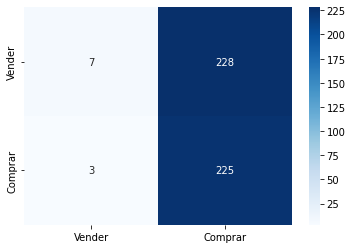

Accuracy: 0.5010799136069114
##################################################
RedeNeural
              precision    recall  f1-score   support

           0       0.70      0.03      0.06       235
           1       0.50      0.99      0.66       228

    accuracy                           0.50       463
   macro avg       0.60      0.51      0.36       463
weighted avg       0.60      0.50      0.35       463



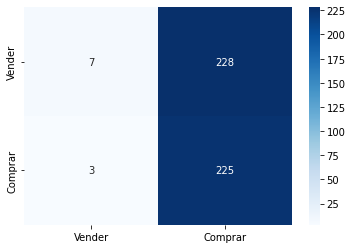

Accuracy: 0.5010799136069114
##################################################


In [89]:
def main(scaled: bool):
    if scaled:
        df = carregar_joblib("../out/result_analise_desc_scaled.joblib")
        print("scaled df")
    else:
        df = carregar_joblib()
        print("NOT scaled df")

    print(df.shape)
    print(df.columns)

    # split database 25% test 75% train
    X_treino, X_teste, y_treino, y_teste = split_dados(df)

    # Run a dummy predict classifier
    dummy_predict = run_dummy_classifier(X_treino, X_teste, y_treino, y_teste)

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino.values, X_teste.values, y_treino.values, y_teste.values)

    # cross validation 
    # for k, v in modelos.items():
    #     print(k)
    #     split_dados_cv(df, v)

    return df

df = main(scaled=True)

## 3 Melhores modelos - acuracia

- AdaBoost - 55%
- GradientBoost - 54%
- RandomForest - 53%
